# Dependencies

## Dependencies

In [2]:
#pip install ucimlrepo

## Helpers

In [148]:
import numpy as np

import pandas as pd

import seaborn as sns

import joblib

from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score

from ucimlrepo import fetch_ucirepo 

def GetDataset(Log = True):
    maternal_health_risk = fetch_ucirepo(id=863) 
    
    # Separar datos, (Pandas DataFrame)
    X = maternal_health_risk.data.features 
    Y = maternal_health_risk.data.targets 
    
    # Información básica del dataset
    if(Log):
        print("URL del repositorio: {}".format(maternal_health_risk.metadata['repository_url']))
        print("Descripción del dataset: {}".format(maternal_health_risk.metadata['abstract']))

        # Información de las variables
        display(maternal_health_risk.variables)

    return X, Y

def GetOutliers(X):
    # Calcular Q1 y Q3 para todas las columnas
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)

    # Calcular el IQR para cada columna
    IQR = Q3 - Q1

    # Identificar outliers
    outliers = (X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))

    return outliers

def OutlierHandler(X):
    # Crear una copia del dataset para no modificar el original
    X_copy = X.copy()
    
    # Obtener los outliers del dataset
    outliers = GetOutliers(X_copy)

    # Para el caso de Age y HeartRate, no se eliminarán los outliers, se reemplazarán por la media
    X_copy.loc[outliers['HeartRate'], 'HeartRate'] = int(X_copy['HeartRate'].mean())
    X_copy.loc[outliers['Age'], 'Age'] = int(X_copy['Age'].mean())
    X_copy.loc[outliers['BS'], 'BS'] = X_copy['BS'].mean()

    # Devolver el nuevo dataset
    return X_copy

def ApplyTransformations(X):
    # Transformaciónes
    XT = pd.DataFrame()


    XT['Age'] = np.log(X['Age'] + 1)

    XT['SystolicBP'], _ = stats.yeojohnson(X['SystolicBP'])
    XT['DiastolicBP'], _ = stats.yeojohnson(X['DiastolicBP'])

    # Logarítmica para BS y BodyTemp
    XT['BS'] = np.log(X['BS'] + 1e-9)


    XT['BodyTemp'] = np.sqrt(X['BodyTemp'])


    # HeartRate no necesita transformación
    XT['HeartRate'] = X['HeartRate']

    return XT

def NormalizeData(X):
    """
    Normaliza los datos de un DataFrame usando MinMaxScaler.
    
    Args:
        X (pd.DataFrame): El DataFrame que contiene los datos a normalizar.

    Returns:
        pd.DataFrame: Un nuevo DataFrame con los datos normalizados.
    """
    normalizer = MinMaxScaler()
    normalized_data = pd.DataFrame(normalizer.fit_transform(X), columns=X.columns)
    return normalized_data

def LabelEncoding(Y):
    # Codificar la variable target, debido a que las etiquetas son high risk, mid risk y low risk.
    label_encoder = LabelEncoder()
    Y_encoded = label_encoder.fit_transform(Y.values.ravel())

    return Y_encoded, label_encoder

def TrainTestSplit(X,Y,test_size = 0.2):    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    return X_train, X_test, Y_train, Y_test

def DatasetSummary(X, Y):
    """
    Función que une X (features) e Y (target), realiza los cálculos de outliers, skewness y kurtosis
    para las variables numéricas, y genera una tabla consolidada con esta información.

    Parámetros:
    X -- DataFrame con las variables independientes (features).
    Y -- Serie con la variable dependiente (target).
    
    Retorna:
    final_summary_df -- DataFrame con la información de las columnas unidas de X y Y,
                        incluyendo outliers, skewness y kurtosis para las variables numéricas.
    """
    # 1. Unir los datasets X y Y en uno solo (asumimos que Y es una Serie)
    combined_df = pd.concat([X, Y], axis=1)

    # 2. Filtrar solo las columnas numéricas de X para hacer los cálculos
    numeric_columns = X.select_dtypes(include=[np.number]).columns

    # 3. Calcular Q1 y Q3 para las columnas numéricas
    Q1 = X[numeric_columns].quantile(0.25)
    Q3 = X[numeric_columns].quantile(0.75)

    # 4. Calcular el IQR para las columnas numéricas
    IQR = Q3 - Q1

    # 5. Identificar outliers solo en las columnas numéricas
    outliers = (X[numeric_columns] < (Q1 - 1.5 * IQR)) | (X[numeric_columns] > (Q3 + 1.5 * IQR))

    # 6. Contar cuántos outliers existen en cada columna numérica
    outliers_count = outliers.sum()

    # 7. Calcular skewness y kurtosis solo para las columnas numéricas
    skewness = X[numeric_columns].skew()
    kurtosis = X[numeric_columns].kurt()

    # 8. Crear un DataFrame con la información general de las columnas
    info_df = pd.DataFrame({
        'Column': combined_df.columns,
        'Non-Null Count': combined_df.notnull().sum().values,
        'Dtype': combined_df.dtypes.values
    })

    # 9. Crear un DataFrame con los cálculos (outliers, skewness y kurtosis)
    summary_df = pd.DataFrame({
        'Outliers': outliers_count,
        'Skewness': skewness,
        'Kurtosis': kurtosis
    })

    # 10. Unir la información general con los cálculos
    final_summary_df = pd.concat([info_df.set_index('Column'), summary_df], axis=1).reset_index()

    # 11. Llenar NaN para las columnas no numéricas y target (Y) en los cálculos de skewness, kurtosis y outliers
    final_summary_df.fillna(value={"Outliers": np.nan, "Skewness": np.nan, "Kurtosis": np.nan}, inplace=True)

    display(final_summary_df)

def DatasetVisualization(X, Y, title="Dataset Overview"):
    num_features = len(X.columns)  # Número de características
    
    # Crear una figura grande
    fig = plt.figure(figsize=(18, 12))
    
    # Añadir un título general al dashboard
    fig.suptitle(title, fontsize=20, y=1.02)  # `y` ajusta la posición vertical del título

    # Crear una cuadrícula con 3 filas y num_features columnas
    gs = gridspec.GridSpec(3, num_features, height_ratios=[1, 1, 2], width_ratios=[1] * 6)

    # Subgráficos para los histogramas en la parte superior
    for i, col in enumerate(X.columns):
        ax_hist = plt.subplot(gs[0, i])
        sns.histplot(X[col], ax=ax_hist, kde=False, bins=10, color='skyblue', edgecolor='black')

    # Subgráficos para las curvas de densidad (KDE) en la segunda fila    
    for i, col in enumerate(X.columns):
        ax_kde = plt.subplot(gs[1, i])
        sns.kdeplot(X[col], ax=ax_kde, color='skyblue')  # Solo la línea de densidad

    # Subgráfico para los boxplots en la tercera fila, ocupando dos columnas
    ax_boxplots = plt.subplot(gs[2, :2])
    X.plot(kind='box', ax=ax_boxplots, subplots=False, patch_artist=True, grid=True, color='skyblue')
    ax_boxplots.set_title("Features", fontsize=16)

    # Subgráfico para la matriz de correlación, ocupando dos columnas (columnas 2 y 3 de la tercera fila)
    ax_corr = plt.subplot(gs[2, 2:4])
    corr_matrix = X.corr()
    sns.heatmap(corr_matrix, annot=True, ax=ax_corr, cmap='coolwarm', cbar=True)
    ax_corr.set_title("Correlation Matrix", fontsize=16)
    
    # Rotar etiquetas de la matriz de correlación en el eje x
    ax_corr.set_xticklabels(ax_corr.get_xticklabels(), rotation=45, horizontalalignment='right')

    # Subgráfico para la exploración de las clases de la variable objetivo, ocupando las últimas dos columnas
    ax_labels = plt.subplot(gs[2, 4:])  # Ocupa desde la columna 4 hasta el final
    y_values = Y.value_counts()

    # Gráfico de barras para la variable objetivo
    y_values.plot(kind='bar', ax=ax_labels, color='skyblue')
    ax_labels.set_title("Labels", fontsize=16)
    ax_labels.set_xlabel("Clase")
    ax_labels.set_ylabel("Frecuencia")
    ax_labels.set_xticklabels(ax_labels.get_xticklabels(), rotation=0)

    # Añadir etiquetas encima de las barras
    for p in ax_labels.patches:
        ax_labels.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.01))

    # Ajustar los gráficos
    plt.tight_layout()
    plt.show()

def KNN_Train(X, Y, n_neighbors=[5, 10, 20], weights=['uniform', 'distance'], Distance=[1, 2]):
    """
    Función para entrenar un modelo K-Nearest Neighbors (KNN) utilizando búsqueda de hiperparámetros
    con GridSearchCV.

    Parámetros:
    -----------
    X : numpy array o pandas DataFrame
        Matriz de características (features) de los datos de entrenamiento.

    Y : numpy array o pandas Series
        Etiquetas (labels) correspondientes a los datos de entrenamiento.

    n_neighbors : list, opcional
        Lista de enteros que representan el número de vecinos a considerar en el algoritmo KNN.
        Valor por defecto: [5, 10, 20]

    weights : list, opcional
        Lista que especifica el tipo de ponderación que se aplicará a los vecinos.
        Opciones: ['uniform', 'distance']
        Valor por defecto: ['uniform', 'distance']
        - 'uniform': Todos los vecinos tienen la misma importancia.
        - 'distance': Los vecinos más cercanos tienen más peso que los más alejados.

    Distance : list, opcional
        Lista de enteros que definen la distancia que se utilizará en la métrica.
        - p=1: Distancia de Manhattan (L1).
        - p=2: Distancia Euclidiana (L2).
        Valor por defecto: [1, 2]

    Retorno:
    --------
    best_knn_model : KNeighborsClassifier
        El mejor modelo KNN encontrado durante la búsqueda de hiperparámetros utilizando GridSearchCV.
    """

    param_grid = {
        'n_neighbors': n_neighbors,     # Número de vecinos
        'weights': weights,             # Tipo de ponderación de los vecinos
        'p': Distance                   # Distancia: p=1: Manhattan, p=2: Euclidiana
    }

    # Realizar búsqueda de hiperparámetros usando GridSearchCV
    grid_search = GridSearchCV(estimator=KNeighborsClassifier(),
                               param_grid=param_grid,
                               scoring='f1_weighted',
                               cv=3,
                               verbose=0,
                               n_jobs=-1)   

    # Ajustar el modelo con los datos de entrenamiento
    grid_search.fit(X, Y)

    # Obtener los mejores hiperparámetros encontrados
    best_knn_model = grid_search.best_estimator_

    return best_knn_model

def RF_Train(X, Y, class_weight, n_estimators=[5, 10, 20, 50], 
                       max_depth=[3, 5, 10], min_samples_split=[3, 5, 10, 20], 
                       min_samples_leaf=[1, 2, 4], bootstrap=[True, False]):
    """
    Función para entrenar un modelo Random Forest utilizando búsqueda de hiperparámetros con GridSearchCV.

    Parámetros:
    -----------
    X : numpy array o pandas DataFrame
        Matriz de características (features) de los datos de entrenamiento.

    Y : numpy array o pandas Series
        Etiquetas (labels) correspondientes a los datos de entrenamiento.

    class_weight : dict
        Diccionario que define los pesos de las clases para compensar el desbalance de datos.

    n_estimators : list, opcional
        Lista de enteros que representan el número de árboles en el bosque.
        Valor por defecto: [5, 10, 20, 50]

    max_depth : list, opcional
        Lista de enteros que especifica la profundidad máxima de los árboles.
        Valor por defecto: [3, 5, 10]

    min_samples_split : list, opcional
        Lista de enteros que define el número mínimo de muestras necesarias para dividir un nodo.
        Valor por defecto: [3, 5, 10, 20]

    min_samples_leaf : list, opcional
        Lista de enteros que especifica el número mínimo de muestras necesarias para estar en una hoja.
        Valor por defecto: [1, 2, 4]

    bootstrap : list, opcional
        Lista que especifica si se utilizará el muestreo con reemplazo (bootstrap).
        Valor por defecto: [True, False]

    Retorno:
    --------
    best_rf_model : RandomForestClassifier
        El mejor modelo Random Forest encontrado durante la búsqueda de hiperparámetros utilizando GridSearchCV.
    """

    # Definir el modelo con los pesos de clase
    random_forest_model = RandomForestClassifier(random_state=42, class_weight=class_weight)

    # Definir el espacio de hiperparámetros para la búsqueda
    param_grid = {
        'n_estimators': n_estimators,               # Número de árboles en el bosque
        'max_depth': max_depth,                     # Profundidad máxima de los árboles
        'min_samples_split': min_samples_split,     # Número mínimo de muestras para dividir un nodo
        'min_samples_leaf': min_samples_leaf,       # Número mínimo de muestras en una hoja
        'bootstrap': bootstrap                      # Usar o no muestreo con reemplazo
    }

    # Realizar búsqueda de hiperparámetros usando GridSearchCV
    grid_search = GridSearchCV(estimator=random_forest_model,
                               param_grid=param_grid,
                               scoring='f1_weighted',  # Puedes cambiar a otra métrica si lo prefieres
                               cv=3,
                               verbose=0,
                               n_jobs=-1)   

    # Ajustar el modelo con los datos de entrenamiento
    grid_search.fit(X, Y)

    # Obtener los mejores hiperparámetros encontrados
    best_rf_model = grid_search.best_estimator_

    return best_rf_model

def train_and_save_rf_model(X_train, Y_train, label):
     # Usar 'balanced' para manejar el desbalanceo de clases automáticamente
    class_weight = 'balanced'

    # Entrenar el Modelo Random Forest
    RF_Model = RF_Train(X_train, Y_train, class_weight)  # Pasar class_weight

    # Guardar el modelo entrenado
    model_filename = f"rf_model_{label}.pkl"
    joblib.dump(RF_Model, model_filename)

    print(f"Modelo Random Forest guardado exitosamente como {model_filename}.")
    return RF_Model

def train_and_save_knn_model(X_train, Y_train, label):
    # Entrenar el Modelo KNN
    KNN_Model = KNN_Train(X_train, Y_train)

    # Guardar el modelo entrenado
    model_filename = f"knn_model_{label}.pkl"
    joblib.dump(KNN_Model, model_filename)

    print(f"Modelo KNN guardado exitosamente como {model_filename}.")
    return KNN_Model

def process_and_train_models(X_train, Y_train, X_test, Y_test, label_encoder, version_label):
    """
    Realiza el procesamiento de datos, entrena los modelos KNN y Random Forest, 
    evalúa su rendimiento, y guarda el mejor modelo y su desempeño.

    Parámetros:
    -----------
    X_train : array-like
        Los datos de entrenamiento de las características (features).
    
    Y_train : array-like
        Las etiquetas correspondientes a los datos de entrenamiento.
    
    X_test : array-like
        Los datos de prueba de las características (features).
    
    Y_test : array-like
        Las etiquetas correspondientes a los datos de prueba.

    label_encoder : LabelEncoder
        El label encoder utilizado para codificar las etiquetas Y.

    version_label : str
        El string que representa la versión de los modelos (ejemplo: "v1.2").
    
    Retorno:
    --------
    None
    """
    # Train and save KNN and Random Forest models
    KNN_Model = train_and_save_knn_model(X_train, Y_train, version_label)
    RF_Model = train_and_save_rf_model(X_train, Y_train, version_label)

    # Save the label encoder
    encoder_filename = f"label_encoder_{version_label}.pkl"
    joblib.dump(label_encoder, encoder_filename)
    print(f"LabelEncoder guardado como {encoder_filename}.")

    # Model Names For Retrieval
    KNN_Model_Name = f"knn_model_{version_label}.pkl"
    RF_Model_Name = f"rf_model_{version_label}.pkl"
    Label_Encoder_Name = f"label_encoder_{version_label}.pkl"

    # Cargar el modelo entrenado
    KNN_Model = joblib.load(KNN_Model_Name)
    RF_Model = joblib.load(RF_Model_Name)

    # Cargar el label encoder
    label_encoder = joblib.load(Label_Encoder_Name)

    # Realizar predicciones y evaluar los modelos con X_test
    y_pred_knn = KNN_Model.predict(X_test)
    y_pred_rf = RF_Model.predict(X_test)

    # Evaluar el rendimiento de los modelos
    knn_accuracy = accuracy_score(Y_test, y_pred_knn)
    rf_accuracy = accuracy_score(Y_test, y_pred_rf)

    knn_f1 = f1_score(Y_test, y_pred_knn, average='weighted')
    rf_f1 = f1_score(Y_test, y_pred_rf, average='weighted')

    # Comparar ambos modelos
    better_model = "KNN" if knn_accuracy > rf_accuracy else "Random Forest"
    if knn_accuracy == rf_accuracy:
        better_model = "Both models perform equally"

    # Mostrar el rendimiento de ambos modelos
    print(f"KNN Accuracy: {knn_accuracy}, F1-score: {knn_f1}")
    print(f"Random Forest Accuracy: {rf_accuracy}, F1-score: {rf_f1}")
    print(f"Better Model: {better_model}")

    # Guardar un archivo con la información de qué modelo es mejor y su rendimiento
    comparison_filename = f"model_comparison_{version_label}.txt"
    with open(comparison_filename, "w") as file:
        file.write(f"KNN Accuracy: {knn_accuracy}, F1-score: {knn_f1}\n")
        file.write(f"Random Forest Accuracy: {rf_accuracy}, F1-score: {rf_f1}\n")
        file.write(f"Better Model: {better_model}\n")

    print(f"Información de comparación guardada como {comparison_filename}.")
    
def load_model(version_label, model_type=""):
    """
    Cargar el modelo entrenado basado en el version_label y el tipo de modelo especificado.
    
    Parámetros:
    -----------
    version_label : str
        El string que representa la versión de los modelos (ejemplo: "v1.2").
    
    model_type : str, opcional
        El tipo de modelo a cargar: "KNN" para K-Nearest Neighbors, "RF" para Random Forest, 
        o si está vacío, carga el mejor modelo basado en el archivo de comparación.

    Retorno:
    --------
    model : sklearn model
        El modelo entrenado (KNN o Random Forest).
        
    label_encoder : LabelEncoder
        El label encoder asociado al modelo.
    """
    # Definir los nombres de los archivos de los modelos
    knn_model_filename = f"knn_model_{version_label}.pkl"
    rf_model_filename = f"rf_model_{version_label}.pkl"
    label_encoder_filename = f"label_encoder_{version_label}.pkl"
    comparison_filename = f"model_comparison_{version_label}.txt"
    
    # Cargar el LabelEncoder
    label_encoder = joblib.load(label_encoder_filename)
    
    # Si model_type está vacío, cargar el modelo mejor basado en el archivo de comparación
    if model_type == "":
        try:
            with open(comparison_filename, "r") as file:
                lines = file.readlines()
                for line in lines:
                    if "Better Model" in line:
                        better_model = line.split(":")[-1].strip()
                        model_type = better_model
                        print(f"El mejor modelo es: {better_model}")
                        break
        except FileNotFoundError:
            raise ValueError(f"No se encontró el archivo de comparación para la versión: {version_label}")
    
    # Cargar el modelo basado en el tipo especificado (KNN o RF)
    if model_type == "KNN":
        model = joblib.load(knn_model_filename)
        print(f"Modelo KNN cargado desde {knn_model_filename}.")
    elif model_type == "RF" or model_type == "Random Forest":
        model = joblib.load(rf_model_filename)
        print(f"Modelo Random Forest cargado desde {rf_model_filename}.")
    else:
        raise ValueError(f"Tipo de modelo no reconocido: {model_type}. Debe ser 'KNN', 'RF' o 'Random Forest'.")
    
    return model, label_encoder

# Dataset Exploration

## Dataset Visual and Statistical Exploration

URL del repositorio: https://archive.ics.uci.edu/dataset/863/maternal+health+risk
Descripción del dataset: Data has been collected from different hospitals, community clinics, maternal health cares from the rural areas of Bangladesh through the IoT based risk monitoring system.


,name,role,type,demographic,description,units,missing_values
0,Age,Feature,Integer,Age,Any ages in years when a women during pregnant.,None,no
1,SystolicBP,Feature,Integer,None,"Upper value of Blood Pressure in mmHg, another...",None,no
2,DiastolicBP,Feature,Integer,None,"Lower value of Blood Pressure in mmHg, another...",None,no
3,BS,Feature,Integer,None,Blood glucose levels is in terms of a molar co...,mmol/L,no
4,BodyTemp,Feature,Integer,None,None,F,no
5,HeartRate,Feature,Integer,None,A normal resting heart rate,bpm,no
6,RiskLevel,Target,Categorical,None,Predicted Risk Intensity Level during pregnanc...,None,no


,index,Non-Null Count,Dtype,Outliers,Skewness,Kurtosis
0,Age,1014,int64,1.0,0.783063,-0.391414
1,SystolicBP,1014,int64,10.0,-0.251189,-0.613382
2,DiastolicBP,1014,int64,0.0,-0.048441,-0.948634
3,BS,1014,float64,210.0,1.868203,2.303174
4,BodyTemp,1014,float64,210.0,1.750988,1.451680
5,HeartRate,1014,int64,2.0,-1.043525,8.398871
6,RiskLevel,1014,object,NaN,NaN,NaN


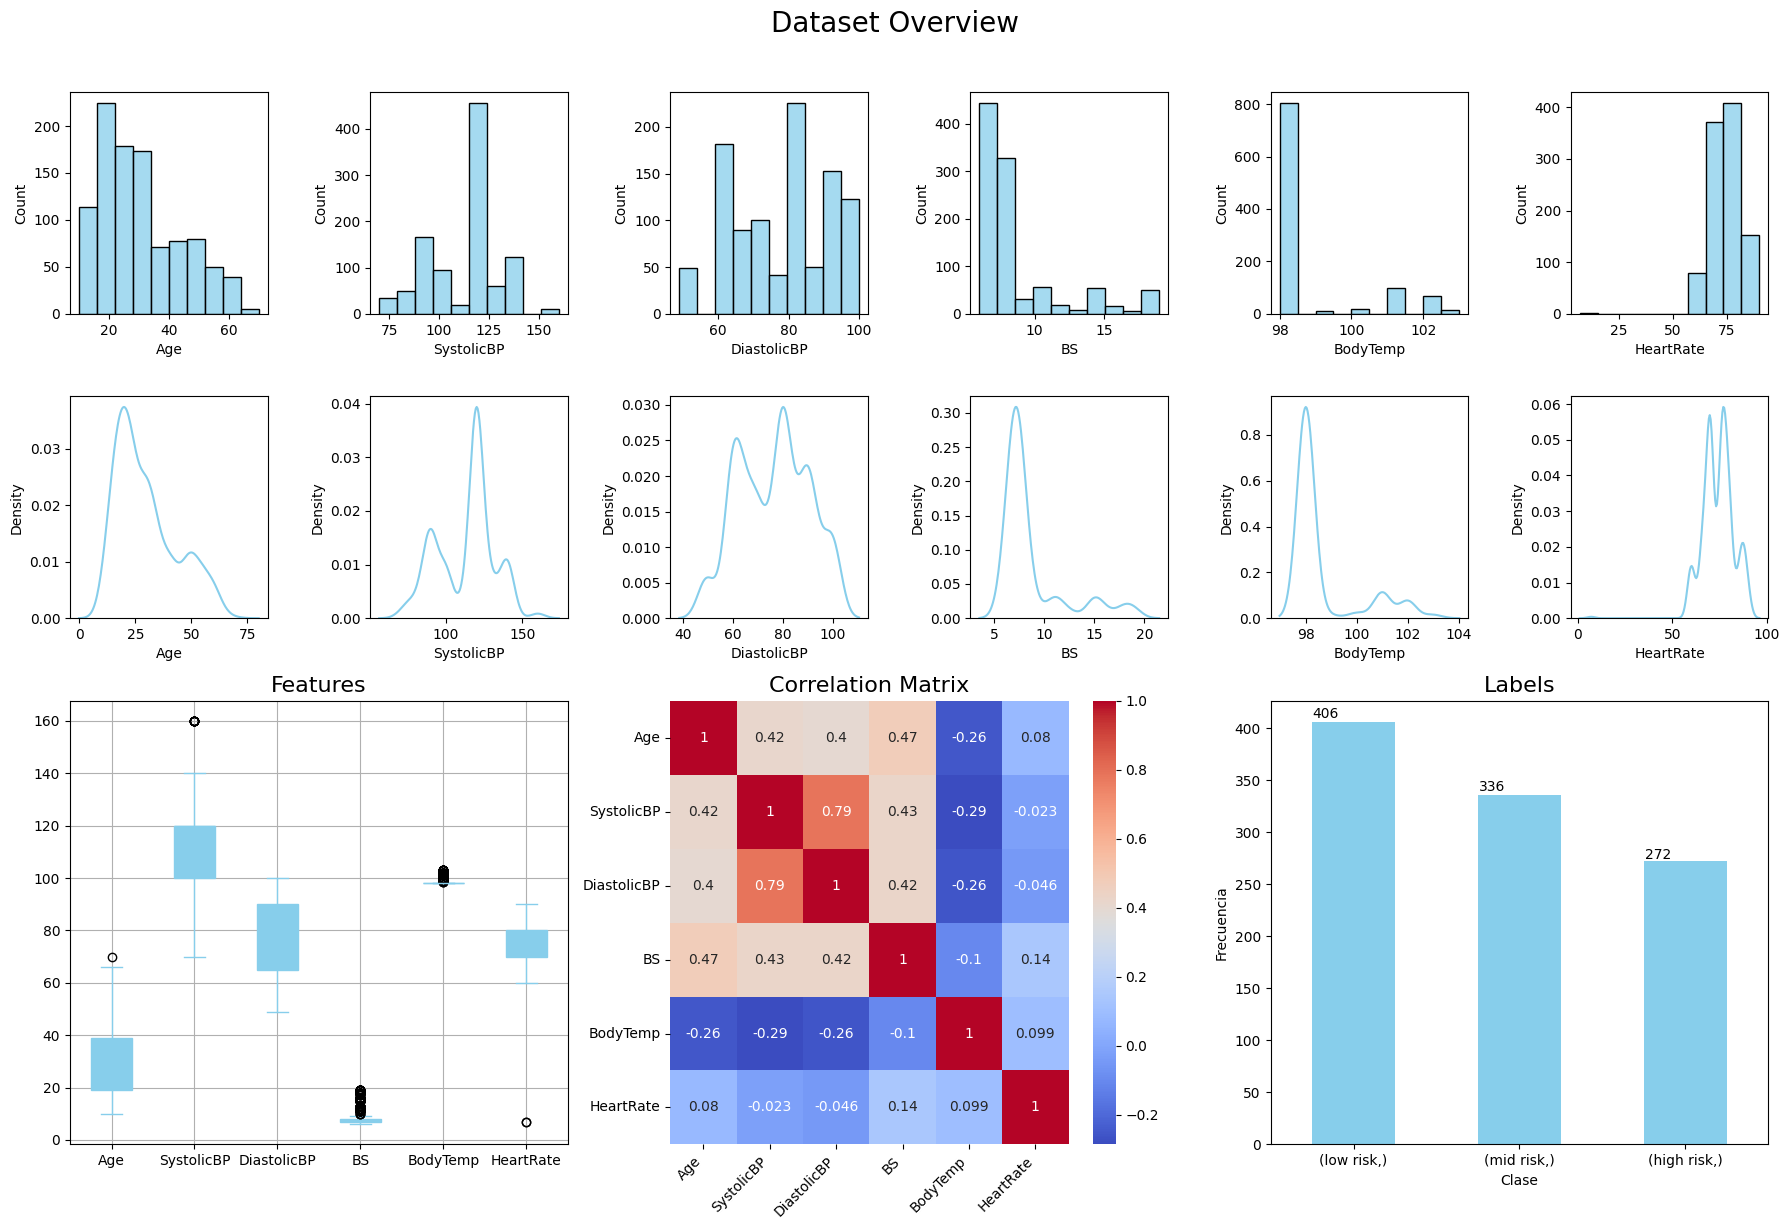

In [85]:
DatasetSummary(*GetDataset())
DatasetVisualization(*GetDataset(Log = False))

### Observaciones sobre las variables independientes:

1. El dataset cuenta con 6 columnas y 1014 registros, sin valores nulos.
2. Las 6 variables son numéricas, dos de ellas son de tipo `float64` (niveles de glucosa en sangre - BS y temperatura corporal - BodyTemp).

### Observaciones sobre la variable objetivo:

1. El dataset tiene una sola columna con 1014 registros, sin valores nulos.
2. La variable objetivo no es numérica.

### Desbalance en las clases de la variable objetivo:

El 27% de los datos corresponde a la clase "high risk", el 33% a "mid risk" y el 40% a "low risk". Para evitar el sesgo hacia la clase mayoritaria, se pueden aplicar varias técnicas:
1. Submuestreo de la clase mayoritaria (no aplicable debido al tamaño del dataset).
2. Sobremuestreo mediante SMOTE.
3. Ajustar los pesos del modelo, dándole más peso a la clase minoritaria durante el entrenamiento (opción seleccionada).

### Análisis estadístico y visual:

- **Age**: La mayoría de los datos se concentran entre 20 y 40 años, con algunos valores atípicos a los 70 años. El sesgo positivo es consistente con esta distribución.
- **SystolicBP**: Presenta un ligero sesgo negativo (-0.25), con una media de 113 y valores atípicos que alcanzan los 160.
- **DiastolicBP**: La media es 76, sin valores atípicos ni sesgo significativo (-0.048).
- **BS**: Se observan valores atípicos con un máximo de 19, mientras que la media es 8.72 y el sesgo positivo es elevado (1.87).
- **BodyTemp**: El valor máximo es 103 y la media 98, con un sesgo positivo (1.75).
- **HeartRate**: Se observa un sesgo negativo (-1.04) debido a un valor atípico de 7, que probablemente sea un error en los datos.

### Observaciones de la matriz de correlación:

- Existe alta correlación positiva entre DiastolicBP y SystolicBP (0.79).
- Tanto SystolicBP como DiastolicBP están correlacionados con la edad (0.42 y 0.4, respectivamente).
- BS también está positivamente correlacionado con SystolicBP y DiastolicBP (0.33 y 0.24), lo que sugiere que mayores niveles de glucosa están relacionados con una mayor presión arterial.
- BodyTemp y HeartRate no muestran relaciones relevantes con las demás variables.

### Imputación de Outliers

- Para el caso de Age, BS y Heart Rate, no se eliminaran los outliers, serán reemplazados por la media

### Transformaciones

- Para **alta asimetría positiva** (como en BS y BodyTemp): Considera usar una transformación logarítmica o de raíz cuadrada en lugar de la inversa.
- Para distribuciones **casi simétricas**(como en HeartRate): Es posible que no necesites aplicar ninguna transformación si la asimetría es cercana a cero.
- Para **ligera asimetría negativa** (como en SystolicBP): Considera usar transformaciones exponenciales o logarítmicas que podrían ayudar a normalizar la distribución.

## Transformations Visualization 

,index,Non-Null Count,Dtype,Outliers,Skewness,Kurtosis
0,Age,1014,float64,0.0,0.140339,-0.902110
1,SystolicBP,1014,float64,10.0,-0.061093,-0.516107
2,DiastolicBP,1014,float64,0.0,-0.057116,-0.945994
3,BS,1014,float64,0.0,0.043264,-0.858521
4,BodyTemp,1014,float64,210.0,1.747102,1.431593
5,HeartRate,1014,float64,0.0,0.066856,-0.479515
6,RiskLevel,1014,object,NaN,NaN,NaN


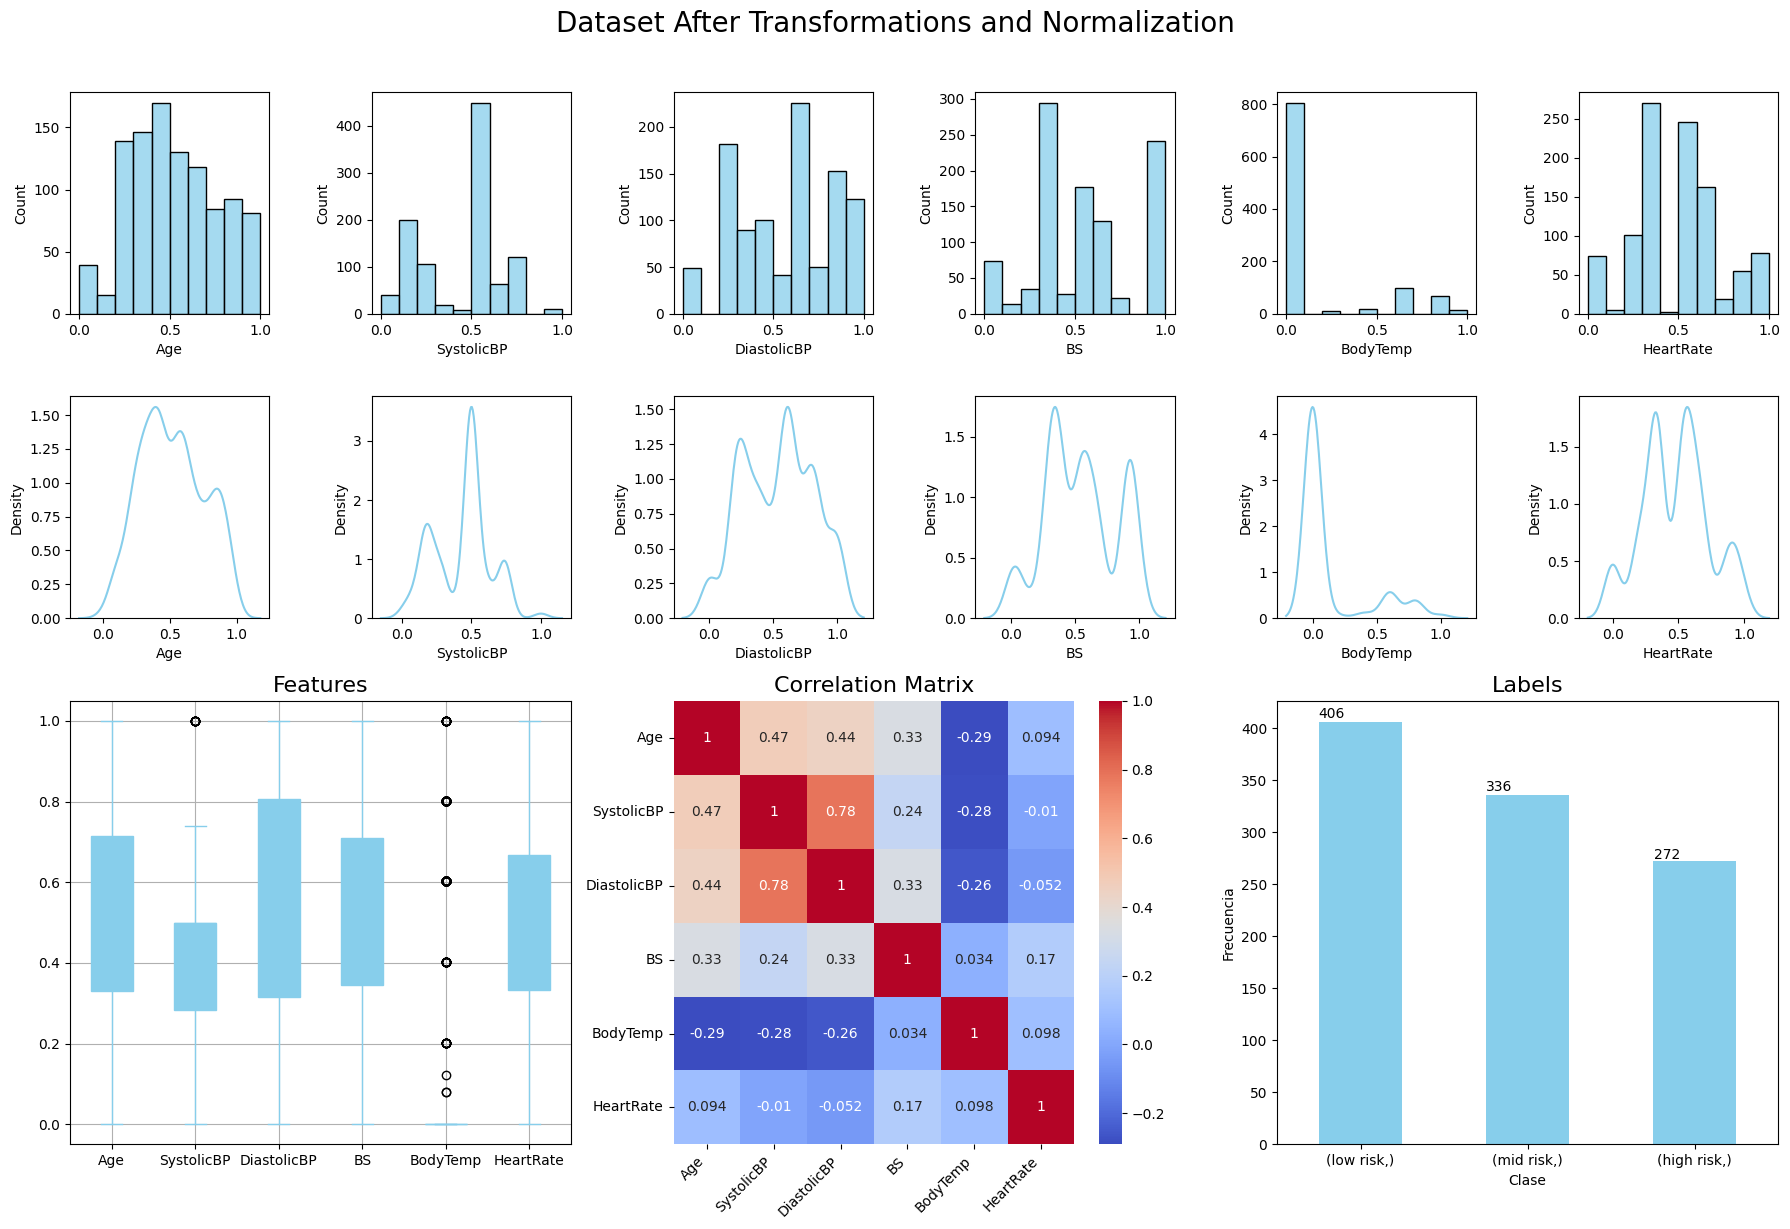

In [86]:
#Get Dataset Information
X,Y = GetDataset(Log=False)

# Features dataset preprocessing pipeline: Outlier Imputation -> Transformations -> Normalization
X = NormalizeData(ApplyTransformations(OutlierHandler(X)))

# Visualizar distribución de los datos
DatasetSummary(X,Y)
DatasetVisualization(X, Y, title="Dataset After Transformations and Normalization")

## Helpers

### Entrenamiento del modelo 1: Bosque aleatorio

### Entrenamiento del modelo 2: KNN

## Model Training

In [149]:
# Label for versioning
version_label = "v0.1"

# Assuming you already have preprocessed data
# Obtener los datos
X, Y = GetDataset(Log=False)

# Features dataset preprocessing pipeline: Outlier Imputation -> Transformations -> Normalization
X = NormalizeData(ApplyTransformations(OutlierHandler(X)))

# Labels dataset preprocessing pipeline: Label Encoding
Y, label_encoder = LabelEncoding(Y)

# Train Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Now call the function and pass the train/test data
process_and_train_models(X_train, Y_train, X_test, Y_test, label_encoder, version_label)

Modelo KNN guardado exitosamente como knn_model_v0.1.pkl.
Modelo Random Forest guardado exitosamente como rf_model_v0.1.pkl.
LabelEncoder guardado como label_encoder_v0.1.pkl.
KNN Accuracy: 0.812807881773399, F1-score: 0.8127028446447684
Random Forest Accuracy: 0.7783251231527094, F1-score: 0.7787656396797481
Better Model: KNN
Información de comparación guardada como model_comparison_v0.1.txt.


## Model Retrieval

In [141]:
version_label = "v0.1"

model, label_encoder = load_model(version_label, model_type="")  # Dejar model_type vacío para cargar el mejor modelo
# Assuming you have test data X_test that is preprocessed
y_pred = model.predict(X_test)

# If you want to decode the predictions back to their original labels (before encoding)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Crear el reporte de clasificación
report = classification_report(Y_test, y_pred, target_names=label_encoder.classes_)

# Mostrar los mejores parámetros y el reporte de clasificación
print(report)
print("Mejores parámetros encontrados:", model)


El mejor modelo es: KNN
Modelo KNN cargado desde knn_model_v0.1.pkl.
              precision    recall  f1-score   support

   high risk       0.85      0.87      0.86        47
    low risk       0.83      0.78      0.80        80
    mid risk       0.78      0.82      0.79        76

    accuracy                           0.81       203
   macro avg       0.82      0.82      0.82       203
weighted avg       0.81      0.81      0.81       203

Mejores parámetros encontrados: KNeighborsClassifier(n_neighbors=20, p=1, weights='distance')
